# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import MinMaxScaler

# Deep learning libraries
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, GRU, Dropout

import warnings
warnings.filterwarnings('ignore')

# Reading The Data

In [2]:
# Load your dataset
data_dir = '/kaggle/input/global-sea-level-rise/sealevel.csv'
df = pd.read_csv(data_dir)

In [3]:
# Assuming your data has the 'Year' column and the months are repeated in the order
# If you don't have a 'Month' column, create it
num_years = df['Year'].nunique()
months = list(range(1, 13)) * num_years
df['Month'] = months[:len(df)]

# Combine 'Year' and 'Month' to create a 'Date' column
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

# Set 'Date' as the index and drop the 'Year' and 'Month' columns if you don't need them
df.set_index('Date', inplace=True)
df.drop(columns=['Year', 'Month'], inplace=True)

# Data Exploration

In [4]:
df.head()

,Unnamed: 0,TotalWeightedObservations,Sea Level,StdDevGMSL_noGIA,SmoothedGSML_noGIA,GMSL_GIA,StdDevGMSL_GIA,SmoothedGSML_GIA,SmoothedGSML_GIA_sigremoved
Date,,,,,,,,,
1993-01-01,0,327401.31,-38.59,89.86,-38.76,-38.59,89.86,-38.75,-38.57
1993-02-01,1,324498.41,-41.97,90.86,-39.78,-41.97,90.86,-39.77,-39.11
1993-03-01,2,331127.31,-39.25,98.10,-36.17,-39.19,98.09,-36.11,-33.48
1993-04-01,3,322756.69,-37.52,87.39,-36.42,-37.45,87.38,-36.35,-33.38
1993-05-01,4,328551.09,-34.52,87.27,-36.81,-34.45,87.27,-36.73,-33.41


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 348 entries, 1993-01-01 to 2021-12-01
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   348 non-null    int64  
 1   TotalWeightedObservations    348 non-null    float64
 2   Sea Level                    348 non-null    float64
 3   StdDevGMSL_noGIA             348 non-null    float64
 4   SmoothedGSML_noGIA           348 non-null    float64
 5   GMSL_GIA                     348 non-null    float64
 6   StdDevGMSL_GIA               348 non-null    float64
 7   SmoothedGSML_GIA             348 non-null    float64
 8   SmoothedGSML_GIA_sigremoved  348 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 27.2 KB


In [6]:
df.describe()

,Unnamed: 0,TotalWeightedObservations,Sea Level,StdDevGMSL_noGIA,SmoothedGSML_noGIA,GMSL_GIA,StdDevGMSL_GIA,SmoothedGSML_GIA,SmoothedGSML_GIA_sigremoved
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,176.545977,326040.626983,3.764885,88.008305,3.797989,7.235920,87.967586,7.268534,8.655718
std,101.869814,31269.679427,26.659550,6.302184,26.504691,28.666988,6.319678,28.517053,28.273243
min,0.000000,36361.000000,-41.970000,78.750000,-39.780000,-41.970000,78.650000,-39.770000,-39.110000
25%,90.750000,327534.077500,-18.195000,84.307500,-17.030000,-16.615000,84.227500,-15.120000,-17.005000
50%,177.500000,333600.450000,-0.570000,86.520000,-1.065000,3.000000,86.435000,2.395000,4.315000
75%,264.250000,335921.585000,25.517500,89.370000,25.547500,30.650000,89.177500,30.600000,30.460000
max,351.000000,340864.500000,53.010000,117.610000,51.990000,59.540000,117.650000,58.780000,60.380000


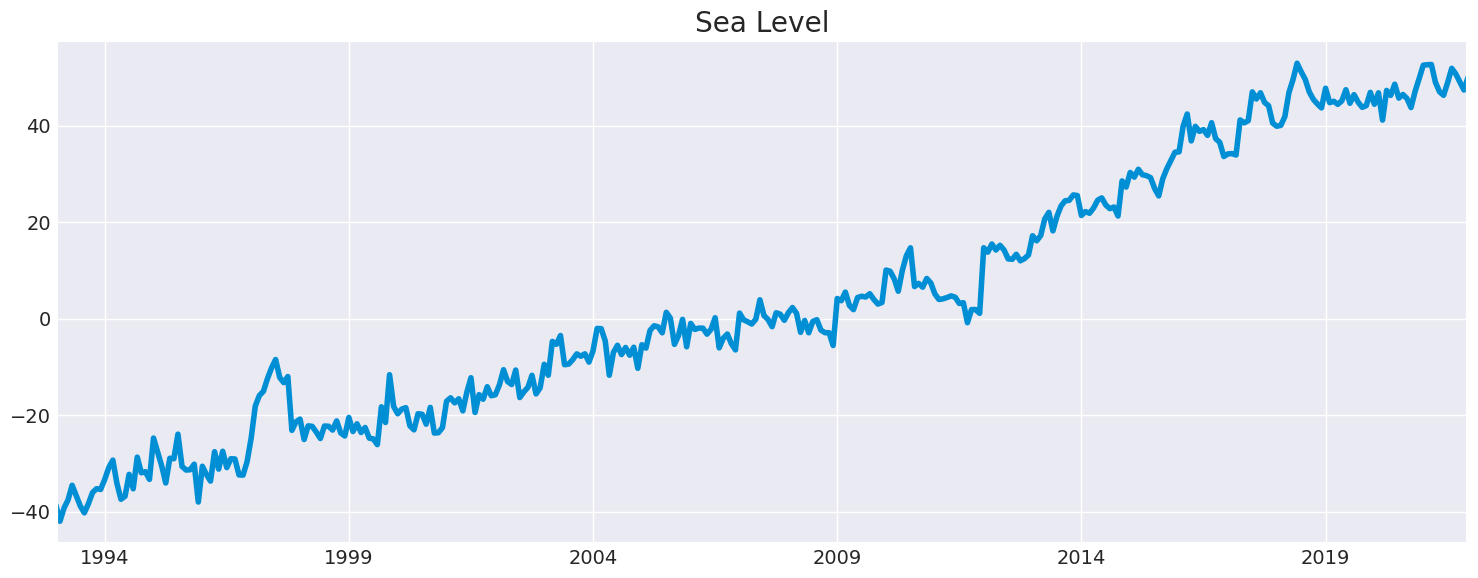

In [7]:
plt.figure(figsize=(15, 6))
df['Sea Level'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Sea Level")
plt.tight_layout()
plt.show()

# Data Preprocessing

## Choosing Prediction Column

In [8]:
dataset = df["Sea Level"]
dataset = pd.DataFrame(dataset)

data = dataset.values
data.shape

(348, 1)

## Normalizing Data

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

## Splitting the Data

In [10]:
# 75% to Train , 25% to Test
train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 261 Test Size : 87


In [11]:
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size-60:, :]

In [12]:
train_data.shape, test_data.shape

((261, 1), (147, 1))

## Creating training set

In [13]:
# Creating a Training set with 60 time-steps
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [14]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [15]:
# Reshaping the input to (n_samples, time_steps, n_feature)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [16]:
x_train.shape, y_train.shape

((201, 60, 1), (201,))

# GRU Model

## Model Structure

In [17]:
model = Sequential([
    GRU(50, return_sequences=True, input_shape = (x_train.shape[1], 1) ),
    GRU(64, return_sequences=False),
    
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer='adam', loss= 'mse', metrics=['mean_absolute_error'])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        22,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,847 (128.31 KB)

 Trainable params: 32,847 (128.31 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [19]:
early_stopping = EarlyStopping(
    patience=10,
    monitor='loss',
    restore_best_weights=True
)

In [20]:
# Fitting the LSTM to the Training set
history = model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=early_stopping)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.1109 - mean_absolute_error: 0.2795
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0286 - mean_absolute_error: 0.1545
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0101 - mean_absolute_error: 0.0819
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0042 - mean_absolute_error: 0.0510
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0049 - mean_absolute_error: 0.0603
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0022 - mean_absolute_error: 0.0377
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0020 - mean_absolute_error: 0.0355
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0018 - mean_absolute_error: 0.0352
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0013 - mean_absolute_error: 0.0283
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0014 - mean_absolute_error: 0.0278
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/ste

## Model Evaluation

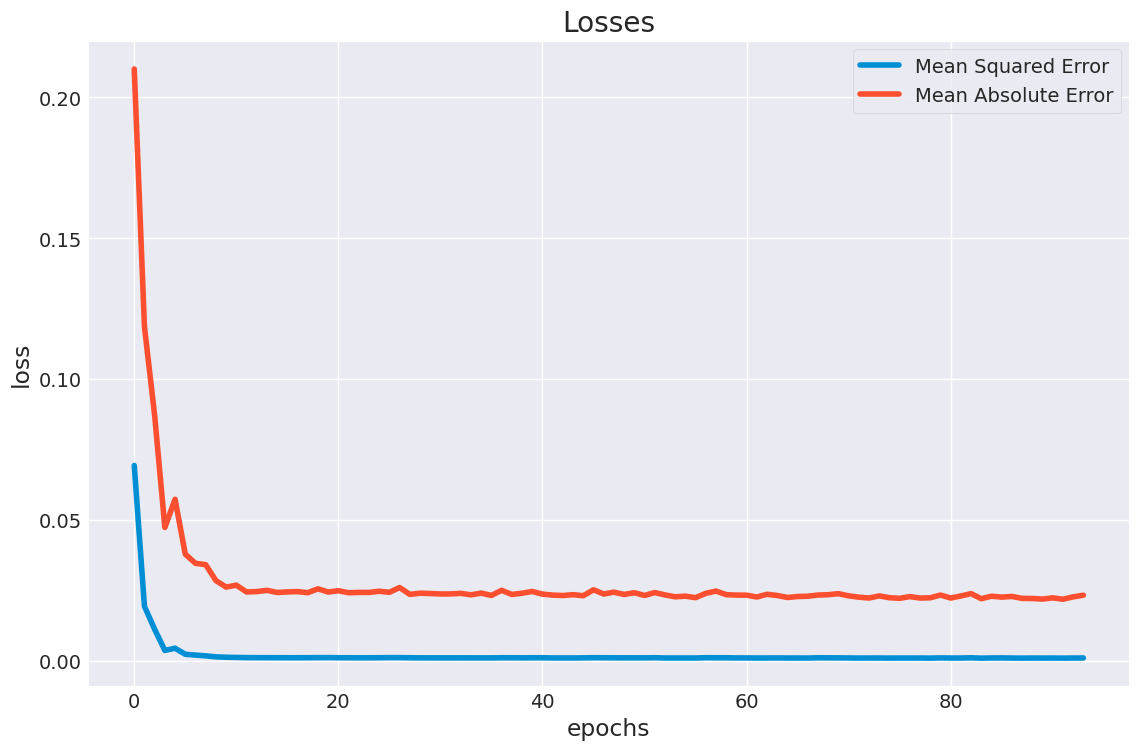

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Predection

## Creating testing set

In [22]:
# Creating a testing set with 60 time-steps and 1 output
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [23]:
x_test, y_test = np.array(x_test), np.array(y_test)

In [24]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [25]:
x_test.shape, y_test.shape

((87, 60, 1), (87,))

In [26]:
# inverse y_test scaling 
predictions = model.predict(x_test)

# inverse predictions scaling 
predictions = scaler.inverse_transform(predictions)
predictions.shape

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step


(87, 1)

## Root mean square error

In [27]:
# inverse y_test scaling 
y_test = scaler.inverse_transform([y_test])

RSME = np.sqrt(np.mean( y_test - predictions)**2).round(2)
RSME

2.55

In [28]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

,Predictions,Actuals
0,21.905642,21.33
1,20.936991,28.60
2,24.112930,27.33
3,25.221663,30.36
4,27.156723,29.39
...,...,...
82,45.904030,51.96
83,48.068195,50.79
84,48.308056,49.15
85,47.396454,47.46


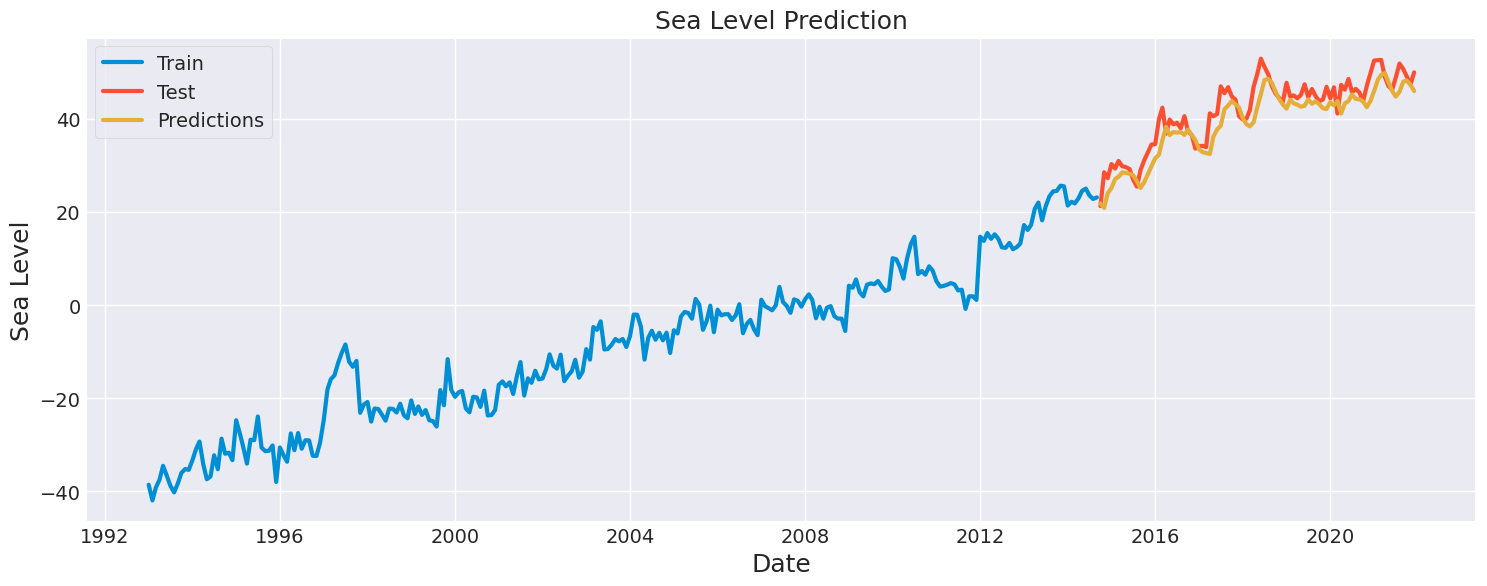

In [29]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Sea Level Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Sea Level', fontsize= 18)
plt.plot(train['Sea Level'], linewidth= 3)
plt.plot(test['Sea Level'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

# Sea Level Forecasting For Next 10 Years

In [30]:
from datetime import timedelta

In [31]:
def insert_end(Xin, new_input):
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [32]:
future = 10 * 365
forcast = []
Xin = x_test[-1 :, :, :]
time = []
for i in range(0, future, 365):
    out = model.predict(Xin, batch_size=5)
    forcast.append(out[0, 0]) 
    print(forcast)
    Xin = insert_end(Xin, out[0, 0]) 
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[0.92671806]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[0.92671806, 0.9126789]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[0.92671806, 0.9126789, 0.8992715]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
[0.92671806, 0.9126789, 0.8992715, 0.8864162]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[0.92671806, 0.9126789, 0.8992715, 0.8864162, 0.87403435]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[0.92671806, 0.9126789, 0.8992715, 0.8864162, 0.87403435, 0.86206824]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[0.92671806, 0.9126789, 0.8992715, 0.8864162, 0.87403435, 0.86206824, 0.8504761]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[0.92671806, 0.9126789, 0.8992715, 0.8864162, 0.87403435, 0.86206824, 0.8504761, 0.8392258]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[0.92671806, 0.9126789, 0.8992715, 0.8864162, 0.87403435, 0.86206824, 0.8504761, 0.8392258, 0.8282926]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[0.92671806, 0.9126789, 0.8992715, 0.8864162, 0.87403435, 0.86206824, 0.8504761, 0.8392258, 0.8282

In [33]:
time

[Timestamp('2021-12-01 00:00:00'),
 Timestamp('2022-12-01 00:00:00'),
 Timestamp('2023-12-01 00:00:00'),
 Timestamp('2024-11-30 00:00:00'),
 Timestamp('2025-11-30 00:00:00'),
 Timestamp('2026-11-30 00:00:00'),
 Timestamp('2027-11-30 00:00:00'),
 Timestamp('2028-11-29 00:00:00'),
 Timestamp('2029-11-29 00:00:00'),
 Timestamp('2030-11-29 00:00:00')]

In [34]:
forcasted_output = np.asanyarray(forcast)   
forcasted_output = forcasted_output.reshape(-1, 1) 
forcasted_output = scaler.inverse_transform(forcasted_output) 

In [35]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", "Forecasted"

In [36]:
df_result

,Date,Forecasted
0,2021-12-01,46.049683
1,2022-12-01,44.716244
2,2023-12-01,43.442806
3,2024-11-30,42.221813
4,2025-11-30,41.045784
5,2026-11-30,39.909241
6,2027-11-30,38.808220
7,2028-11-29,37.739670
8,2029-11-29,36.701233
9,2030-11-29,35.690914


In [37]:
df_result.set_index('Date', inplace=True)

In [38]:
df_result

,Forecasted
Date,
2021-12-01,46.049683
2022-12-01,44.716244
2023-12-01,43.442806
2024-11-30,42.221813
2025-11-30,41.045784
2026-11-30,39.909241
2027-11-30,38.808220
2028-11-29,37.739670
2029-11-29,36.701233


<Axes: xlabel='Date'>

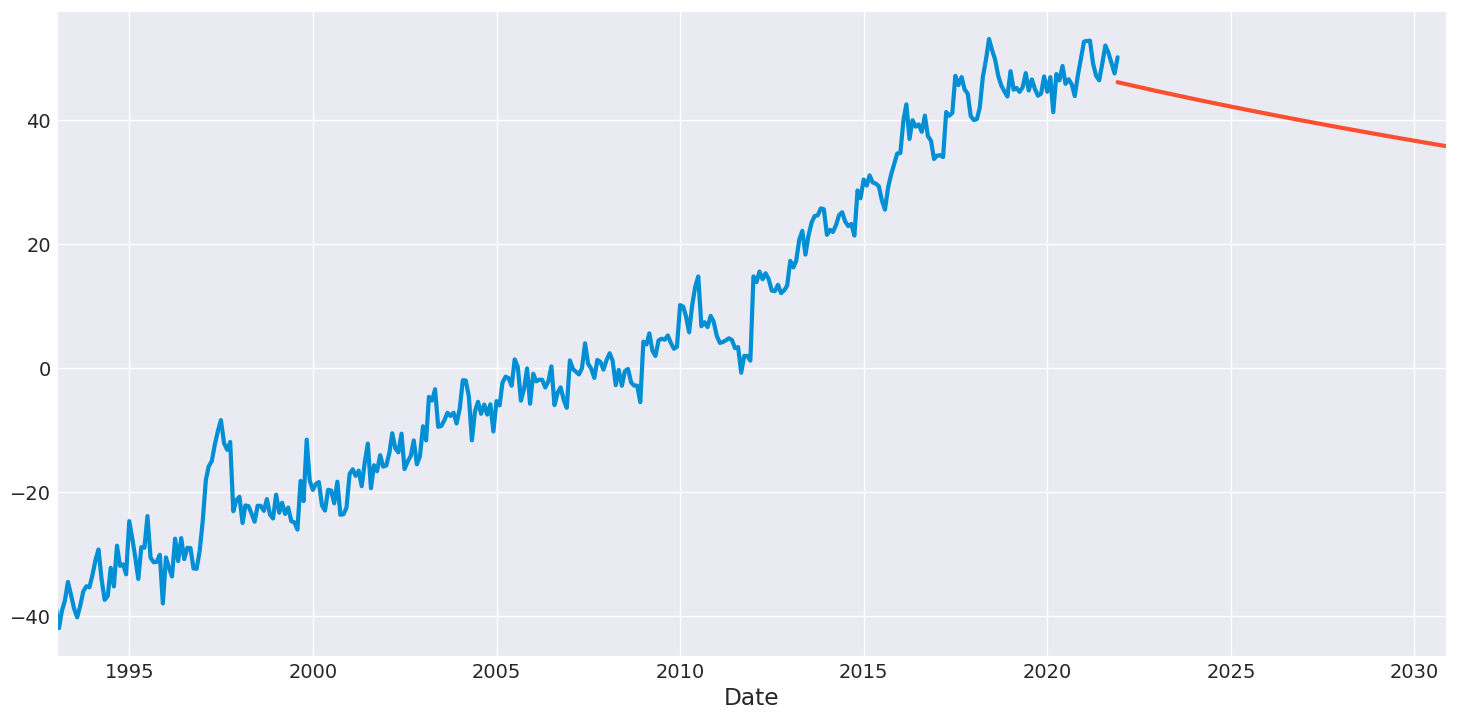

In [39]:
plt.figure(figsize=(16,8))
plt.title('Sea Level Rising Forecasting')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Sea Level' ,fontsize=18)
df['Sea Level'].plot(linewidth=3)
df_result['Forecasted'].plot(linewidth=3)